In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns
from scipy.optimize import minimize

# <font face="gotham" color="purple"> Simple Linear Regression</font>

This is a simple linear regression model as in every econometrics textbooks
$$
Y_i=\beta_1+\beta_2X_i+u_i
$$
where $Y$ is **dependent variable**, $X$ is **independent variable** and $u$ is **disturbance term**. $\beta_1$ and $\beta_2$ are unknown parameters that we are aiming to estimate by feeding the data in the model. Without disturbance term, the model is simple a function of a straight line in $\mathbb{R}^2$, such as
$$
Y = 2 + 3X
$$

In the context of _machine learning_ (ML), the $X$ is usually called **feature variable** and $Y$ called **target variable**. And linear regression is the main tool in **supervised learning**, meaning that $Y$ is supervising $X$./


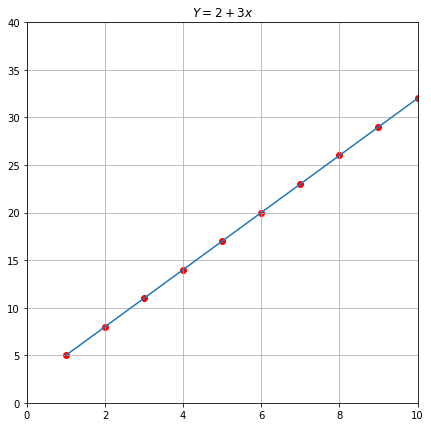

In [2]:
X = np.linspace(1, 10, 10)
Y = 2 + 3 * X
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(X, Y)
ax.scatter(X, Y, c="r")
ax.grid()
ax.set_title("$Y=2+3x$")
ax.set_xlim(0, 10)
ax.set_ylim(0, 40)
plt.show()

There are five reasons justified that we need a disturbance term:

<i>1. omission of independent variables</i><br>
<i>2. aggregation of variables</i><br>
<i>3. model misspecification</i><br>
<i>4. function misspecification, eg. should be nonlinear rather than linear</i><br>
<i>5. measurement error</i>
    

The second one means that if we intend to aggregate the variable to a macro level, for instance every family has a consumption function, but aggregation on a national level causes discrepancies which contribute to the disturbance term.

The third and forth one will be discussed in details in later chapter.

The fifth one includes all types of error, man-made or natural. 

# <font face="gotham" color="purple"> Odinary Least Squares</font>

**Odinary Least Squares** is the most common estimation technique used in ML or econometrics, it is popular due to its _simplicity_ and _transparency_. You'll be able to derive the whole estimation process by hand-calculation, all steps will have _closed-form expression_.

We'll demonstrate OLS with our first plot. Every time you run this script, the result will be different than mine, because no random seeds are set.

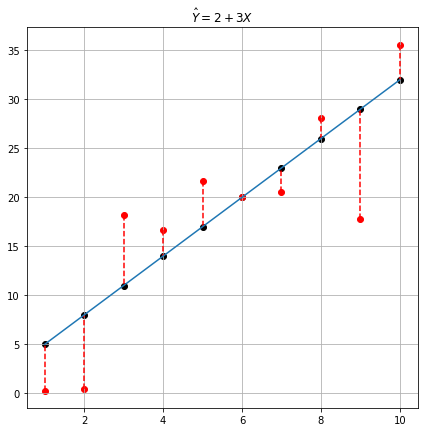

In [3]:
beta1, beta2 = 2, 3


def gen_linreg_data(beta1, beta2, samp_size, disturb_scale):

    X = np.linspace(1, 10, samp_size)
    u = disturb_scale * np.random.randn(samp_size)
    Y = beta1 + beta2 * X + u
    Y_hat = beta1 + beta2 * X
    return X, Y, Y_hat


def plot_lin_reg(X, Y, Y_hat):
    fig, ax = plt.subplots(figsize=(7, 7))

    for i in range(len(Y)):
        dot_fit_values = [X[i], X[i]]
        dot_org_values = [Y[i], Y_hat[i]]
        ax.plot(
            dot_fit_values,
            dot_org_values,
            linestyle="--",
            color="red",
            label="residual",
        )

    ax.plot(X, Y_hat)
    ax.scatter(X, Y_hat, c="k")
    ax.scatter(X, Y, c="r")
    ax.grid()
    ax.set_title("$\hat Y ={}+{}X$".format(beta1, beta2))
    plt.show()


if __name__ == "__main__":
    X, Y, Y_hat = gen_linreg_data(
        beta1=beta1, beta2=beta2, samp_size=10, disturb_scale=5
    )
    plot_lin_reg(X, Y, Y_hat)

We have plotted a fitted line onto $10$ observations (red dots) which was generated by $Y_i = 2+3X_i+5u_i$, where $u_i \sim N(0, 1)$. For easy demonstration, say we have a 'perfect' estimator that provides
$$
\hat{\beta}_1 = 2\\
\hat{\beta}_2 = 3
$$
where $\hat{\beta}_1 $ and $\hat{\beta}_2$ are estimates, in contrast $\beta_1$ and $\beta_2$ are model parameters.

Therefore we can plot a fitted line (blue line) $\hat{Y} = 2+3X$. The red dashed line is the difference of $Y_i$ and $\hat{Y}_i$, we officially call it **residual**, denoted as $\varepsilon_i$.
$$
\varepsilon_i = Y_i - \hat{Y}_i = Y_i - \hat{\beta}_1-\hat{\beta}_2X_i
$$
The OLS algorithm is aiming find the estimates of $\beta_1$ and $\beta_2$ such that
$$
\text{min}\text{ RSS}=\sum_{i=1}^n \varepsilon^2_i 
$$
where $RSS$ is the **residual sum of squares** $(\text{RSS})$. 

In ML context, notation is slightly different, but the ideas are the same, a **cost function** is defined with $\text{RSS}$
$$
J(\hat{\beta_1}, \hat{\beta}_2) = \frac{1}{2m} \sum_{i=1}^n \varepsilon^2_i 
$$
Then minimize the cost function
$$
\text{min }J(\hat{\beta_1}, \hat{\beta}_2)
$$

To minimise the $RSS$, we simply take _partial derivatives_ w.r.t. $b_2$ and $b_1$ respectively. The results are the OLS estimators of simple linear regression, which are 
\begin{align}
\hat{\beta}_2 &=\frac{\sum_{i=1}^n(X_i-\bar{X})(Y_i-\bar{Y})}{\sum^n_{i=1}(X_i-\bar{X})^2}=\frac{\text{Cov}(X, Y)}{\text{Var}(X)}\\
\hat{\beta}_1 &= \bar{Y}-\hat{\beta}_2\bar{X}
\end{align}

With these formulae in mind, let's perform a serious OLS estimation. Considering possible repetitive use of OLS in this tutorial, we will write a class for OLS. 

In [4]:
class S_OLS:
    """Create instances with S_OLS(X, Y), where X and Y are data array."""

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def ols(self):
        """Estimate the data with OLS method, and return b1 and b2."""
        cov_mat = np.cov(self.X, self.Y)
        self.b2 = cov_mat[0, 1] / cov_mat[0, 0]
        self.b1 = np.mean(self.Y) - self.b2 * np.mean(self.X)
        self.Y_hat = self.b1 + self.b2 * self.X
        print("b1 estimate: {:.4f}".format(self.b1))
        print("b2 estimate: {:.4f}".format(self.b2))
        return self.Y_hat, self.b2, self.b1

    def simul_plot(self, beta1, beta2):
        """Plot scatter plot and fitted line with ols_plot(self, beta1, beta2),
        beta1 and beta2 are parameters of data generation process."""
        fig, ax = plt.subplots(figsize=(7, 7))
        for i in range(len(Y)):
            dot_fit_values = [self.X[i], self.X[i]]
            dot_org_values = [self.Y[i], self.Y_hat[i]]
            ax.plot(dot_fit_values, dot_org_values, linestyle="--", color="red")
        ax.scatter(self.X, self.Y_hat, c="k")
        ax.scatter(self.X, self.Y, c="r")
        ax.plot(self.X, self.Y_hat, label="$b_1$= {:.2f}, $b_2$={:.2f}".format(b1, b2))
        ax.grid()
        ax.set_title("$\hat Y ={:.2f}+{:.2f}X$".format(b1, b2))
        Y_hat_perfect = beta1 + beta2 * X
        ax.plot(X, Y_hat_perfect, label=r"$\beta_1=2, \beta_2=3$")
        ax.legend()
        plt.show()

    def ols_plot(self, xlabel, ylabel):
        self.xlabel = xlabel
        self.ylabel = ylabel
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.scatter(self.X, self.Y_hat, c="k")
        ax.scatter(self.X, self.Y, c="r")
        ax.plot(
            self.X,
            self.Y_hat,
            label="$b_1$= {:.2f}, $b_2$={:.2f}".format(self.b1, self.b2),
        )
        ax.grid()
        ax.set_title("$\hat Y ={:.2f}+{:.2f}X$".format(self.b1, self.b2))
        ax.set_xlabel(self.xlabel)
        ax.set_ylabel(self.ylabel)

    def r_sq(self):
        """Calculate coefficient of determination and correlation of Y and Yhat"""
        self.ESS = np.var(self.Y_hat)
        self.RSS = np.var(self.Y - self.Y_hat)
        self.R_sq = self.ESS / self.RSS
        return self.ESS, self.RSS, self.R_sq

In [5]:
X, Y, Y_hat = gen_linreg_data(beta1=4, beta2=2, samp_size=15, disturb_scale=3)

In [6]:
np.corrcoef(X, Y)

array([[1.        , 0.88496253],
       [0.88496253, 1.        ]])

In [7]:
s_ols = S_OLS(X, Y)
Y_hat, betahat2, betahat1 = s_ols.ols()

b1 estimate: 4.8314
b2 estimate: 1.9802


A convenient function ```np.polyfit``` of curve fitting could verify our results.

In [8]:
np.polyfit(X, Y, 1)

array([1.98022248, 4.83137211])

The plot the fitted line $b_1+b_2X$, original line $\beta_1+\beta_2X$ and observations.

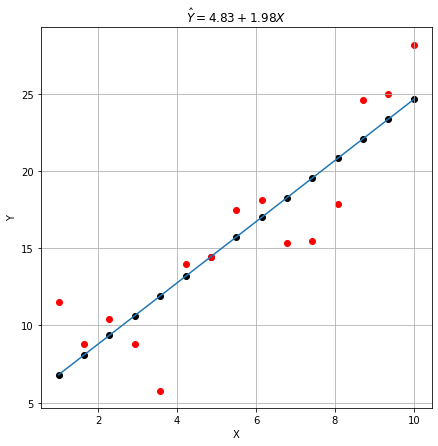

In [9]:
s_ols.ols_plot("X", "Y")

From the estimation result and graph above, we can notice $\hat{\beta}_1$ and $\hat{\beta}_2$ are close to true parameters $\beta_1$ and $\beta_2$ if scalar of disturbance term is small.

# <font face="gotham" color="purple"> Interpretation of Estimated Coefficients</font>

We will check on a real data set to understand basic principles of interpreting estimates. The data set collected  average apartment price ¥/$m^2$ and average annual disposable income from $25$ Chinese cities in 2020. 

Load the data with Pandas.

In [10]:
df = pd.read_excel(
    "Basic_Econometrics_practice_data.xlsx", sheet_name="CN_Cities_house_price"
)
df.head()

,cities,house_price,salary
0,Shenzhen,87957,64878
1,Beijing,64721,69434
2,Shanghai,59072,72232
3,Xiamen,49803,58140
4,Guangzhou,39851,68304


Estimate parameters with OLS algorithm.

In [11]:
s_ols_house_income = S_OLS(df["salary"], df["house_price"])
Y_hat, b2, b1 = s_ols_house_income.ols()

b1 estimate: -29181.1698
b2 estimate: 1.1010


Plot the observation and regression line.

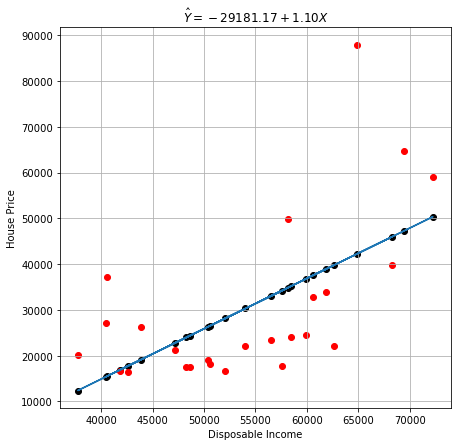

In [12]:
s_ols_house_income.ols_plot("Disposable Income", "House Price")

$\hat{\beta}_2$ can be interpreted literally as the graph shows, as disposable income increases $1$ yuan (Chinese currency unit), the house price increases $1.1$ yuan. 

As for $\hat{\beta}_1$, it is tricky to interpret the face value that if the disposable income is zero, i.e. the house price is $-29181$ yuan if disposable income is $0$, it doesn't make any sense. The basic principle of interpreting constant term is to check if it has a plausible meaning when all independent/feature variables equals zero. If no sensible meaning, you don't need to interpret it, this is a well known defect of linear regression model.

# <font face="gotham" color="purple"> Important Results of OLS</font>

Some features of OLS could provide us insights of mechanism of the algorithm. 

The _first_ one is 
$$
\bar{\varepsilon}=0
$$
It is true because
$$
\bar{\varepsilon}=\bar{Y}-\hat{\beta}_1-\hat{\beta}_2\bar{X}=\bar{Y}-(\bar{Y}-\hat{\beta}_2\bar{X})-\hat{\beta}_2\bar{X}=0
$$
holds. We can demonstrate numerically with the variables that we have defined in house price example.

In [13]:
epsilon = df["house_price"] - Y_hat
np.mean(epsilon)

2.473825588822365e-12

It is not theoretically zero due to some numerical round-off errors, but we treat it as zero.

The _second_ feature is 
$$
\bar{\hat{Y}}=\bar{Y}
$$

In [14]:
print("Mean of Y hat: {}".format(np.mean(Y_hat)))
print("Mean of Y: {}".format(np.mean(df["house_price"])))

Mean of Y hat: 30218.879999999994
Mean of Y: 30218.88


The _third_ and _forth_ features are
$$
\sum_i^n X_i\varepsilon_i=0\\
\sum_i^n \hat{Y}_i\varepsilon_i=0
$$

This can be shown by using a _dot product_ function. 

In [15]:
print(np.dot(df["salary"], epsilon))
print(np.dot(Y_hat, epsilon))

3.814697265625e-06
1.9073486328125e-06


Actually, lots of econometric theory can be conveniently derived by linear algebra. 

For instance, in linear algebra, covariance has a geometric interpretation
$$
\text{Cov}(X, Y)=x\cdot y= ||x||||y||\cos{\theta}
$$
where $x$ and $y$ are vectors in $\mathbb{R}^n$. If dot product equals zero, geometrically these two vectors are perpendicular, denote as $x\perp y$. Therefore the third and forth features are equivalent to
$$
\text{Cov}(X, e)=0\\
\text{Cov}(\hat{Y}, e)=0
$$
i.e. $x\perp e$ and $\hat{y} \perp e$. Traditionally, the vectors are denoted as lower case letters.

# <font face="gotham" color="purple"> Variance of Decomposition</font>

**Variance of decomposition** is based on analysis of variance (ANOVA), if you don't know what ANOVA is, <a href='https://github.com/MacroAnalyst/Basic_Statistics_With_Python/blob/main/Chapter%205%20-%20Analysis%20of%20Variance%20and%20Chi-Squared%20Test.ipynb'>check here</a>. We know that any observation can be decomposed as a fitted value and a residual
$$
Y_i = \hat{Y}_i+\varepsilon_i
$$
Take variance on both sides
$$
\text{Var}(Y)=\text{Var}(\hat{Y}+\varepsilon)=\operatorname{Var}(\hat{Y})+\operatorname{Var}(\varepsilon)+ \underbrace{2 \operatorname{Cov}(\hat{Y}, \varepsilon)}_{=0}
$$
Or in the explicit form
$$
\frac{1}{n} \sum_{i=1}^{n}\left(Y_{i}-\bar{Y}\right)^{2}=\frac{1}{n} \sum_{i=1}^{n}\left(\hat{Y}_{i}-\overline{\hat{Y}}\right)^{2}+\frac{1}{n} \sum_{i=1}^{n}\left(\varepsilon_{i}-\bar{\varepsilon}\right)^{2}
$$

Use the OLS features, i.e. $\bar{\hat{Y}}=\bar{Y}$ and $\bar{\varepsilon}=0$, the equation simplifies into
$$
\underbrace{\sum_{i=1}^{n}\left(Y_{i}-\bar{Y}\right)^{2}}_{TSS}=\underbrace{\sum_{i=1}^{n}\left(\hat{Y}_{i}-\bar{Y}\right)^{2}}_{ESS}+\underbrace{\sum_{i=1}^{n} \varepsilon_{i}^{2}}_{RSS}
$$
where $TSS$ means **total sum of squares**, $ESS$ means **explained sum of squares**.

# <font face="gotham" color="purple"> Coefficient of Determination</font>

Though $ESS$ is called 'explained' part, it might be entirely wrong due to misspecification of model. That being said, we still need a quantitative indicator that tells us how much the model is able to 'explain' the behaviour of the dependent variables. 

The **coefficient of determination** is most intuitive indicator
$$
R^2 = \frac{ESS}{TSS}=\frac{\sum_{i=1}^{n}\left(\hat{Y}_{i}-\bar{Y}\right)^{2}}{\sum_{i=1}^{n}\left(Y_{i}-\bar{Y}\right)^{2}}
$$

We have written a ```r_sq()``` method in the ```S_OLS``` class.

In [16]:
ess, rss, r_sq = s_ols_house_income.r_sq()
print(r_sq)

0.5744603125471681


It means the disposable income can explain $57\%$ of house price variation. Furthermore, 
$$
R^2 = \frac{TSS - RSS}{TSS}=1-\frac{RSS}{TSS}
$$
it is clear that minimise $RSS$ is equivalent to maximise $R^2$.

Alternatively, the $R^2$ can be shown its relationship with correlation coefficient $r_{Y, \hat{Y}}$.

$$
\begin{aligned}
r_{Y, \hat{Y}} &=\frac{\operatorname{Cov}(Y, \hat{Y})}{\sqrt{\operatorname{Var}(Y) \operatorname{Var}(\hat{Y})}}=\frac{\operatorname{Cov}([\hat{Y}+e], \hat{Y})}{\sqrt{\operatorname{Var}(Y) \operatorname{Var}(\hat{Y})}}=\frac{\operatorname{Cov}(\hat{Y}, \hat{Y})+\operatorname{Cov}(e, \hat{Y})}{\sqrt{\operatorname{Var}(Y) \operatorname{Var}(\hat{Y})}}=\frac{\operatorname{Var}(\hat{Y})}{\sqrt{\operatorname{Var}(Y) \operatorname{Var}(\hat{Y})}} \\
&=\frac{\sqrt{\operatorname{Var}(\hat{Y}) \operatorname{Var}(\hat{Y})}}{\sqrt{\operatorname{Var}(Y) \operatorname{Var}(\hat{Y})}}=\sqrt{\frac{\operatorname{Var}(\hat{Y})}{\operatorname{Var}(Y)}}=\sqrt{R^{2}}
\end{aligned}
$$

# <font face="gotham" color="purple"> Gauss-Markov Conditions</font>

In order to achieve the best estimation by OLS, the disturbance term ideally has to satisfy four conditions which are called **Gauss-Markov Conditions**. Provided that all G-M conditions satisfied, OLS is the preferred over all other estimators, because mathematically it is proved to be the **Best Linear Unbiased Estimator** (BLUE). This conclusion is called **Gauss-Markov Theorem**.

1. $E(u_i|X_i)=0$
2. $E(u_i^2|X_i)= \sigma^2$ for all $i$, **homoscedasticity**
3. $\text{Cov}(u_i, u_j)=0, \quad i\neq j$, no **autocorrelation**.
4. $\text{Cov}(X_i, u_i)=0$, assuming $X_i$ is non-stochastic.

In addition to G-M conditions, we also assume normality of disturbance term, i.e. $u_i\sim N(0, \sigma^2_u)$, which is guaranteed by _Central Limit Theorem_.

In practice, almost impossible to have all conditions satisfied simultaneously or even one perfectly, but we must be aware of severity of violations, because any violation of G-M condition will compromise the quality of estimation results. And identifying which condition is violated could also lead us to corresponding remedies.

# <font face="gotham" color="purple"> Random Components of Regression Coefficients</font>

According to the OLS formula of $\beta_2$
$$
\hat{\beta}_{2}=\frac{\operatorname{Cov}(X, Y)}{\operatorname{Var}(X)}
$$

Plug in $Y=\beta_1+\beta_2X+u$:
$$
\hat{\beta}_{2}=\frac{\operatorname{Cov}(X, Y)}{\operatorname{Var}(X)}=\frac{\operatorname{Cov}(X, \beta_1+\beta_2X+u)}{\operatorname{Var}(X)}
$$

The covariance operation rules come in handy
$$
\operatorname{Cov}(X, \beta_1+\beta_2X+u)=\operatorname{Cov}\left(X, \beta_{1}\right)+\operatorname{Cov}\left(X, \beta_{2} X\right)+\operatorname{Cov}(X, u)
$$

where $\operatorname{Cov}\left(X, \beta_{1}\right)=0$, and $\operatorname{Cov}\left(X, \beta_{2} X\right)=\beta_2 \operatorname{Var}(X)$, therefore
$$
\hat{\beta}_{2}=\frac{\operatorname{Cov}(X, Y)}{\operatorname{Var}(X)}=\beta_{2}+\frac{\operatorname{Cov}(X, u)}{\operatorname{Var}(X)}
$$

If $u$ perfectly uncorrelated with $X$ as in G-M condition, the second term should be $0$. However that rarely happens, so the $\hat{\beta}_2$ and $\beta_2$ will always have certain level of discrepancy. And note that we can't decompose $\hat{\beta}_2$ in practice, because we don't know the true value of $\beta_2$.

And also note that there are two ways to improve the accuracy of $\hat{\beta}_2$, either lower the correlation of $X$ and $u$ or increase the variance of $X$.

## <font face="gotham" color="purple"> Monte Carlo Sampling Distribution</font>

We want to perform a Monte Carlo simulation to show the sampling distribution of $\hat{\beta}_1$ and $\hat{\beta}_2$. First, we write a simple class for OLS Monte Carlo experiment. 

We can set $\beta_1$, $\beta_2$, $N$ and $a_u$ for initialisation. The model is
$$
Y_i=\beta_1+\beta_2X_i +a_uu_i, \qquad i\in(1, n),\qquad u_i\sim N(0,1)
$$

In [46]:
class OLS_Monte_Carlo:
    def __init__(self, beta1, beta2, N, u_scaler):
        """Input beta1, beta2, sample size, scaler of disturbance"""
        self.beta1 = beta1
        self.beta2 = beta2
        self.u_scaler = u_scaler
        self.N = N
        self.X = self.N * np.random.rand(
            self.N
        )  # generate N random X's in the range of (0, N)

    def ols(self):
        """Estimate the data with OLS method, and return b1 and b2."""
        self.u = self.u_scaler * np.random.randn(self.N)
        self.Y = self.beta1 + self.beta2 * self.X + self.u
        cov_mat = np.cov(self.X, self.Y)
        self.b2 = cov_mat[0, 1] / cov_mat[0, 0]
        self.b1 = np.mean(self.Y) - self.b2 * np.mean(self.X)
        return self.b2, self.b1

Instantiate the OLS Monte Carlo object with $\beta_1=2$, $\beta_2=3$, $n=10$ and $a_u=1$, then run $10000$ times of simulations, each time generated a new $u$. All estimated $\hat{\beta}_1$ and $\hat{\beta}_2$ are collected in their arrays.

In [47]:
ols_mt = OLS_Monte_Carlo(beta1=2, beta2=3, N=10, u_scaler=1)
b2_array, b1_array = [], []
for i in range(10000):
    b2, b1 = ols_mt.ols()
    b2_array.append(b2)
    b1_array.append(b1)
b2_mean = np.mean(b2_array)
b1_mean = np.mean(b1_array)

Plot the histogram and the mean of estimates. Not difficult to notice that the mean of the $\hat{\beta}_1$ and $\hat{\beta}_2$ are very close to 'true values'.

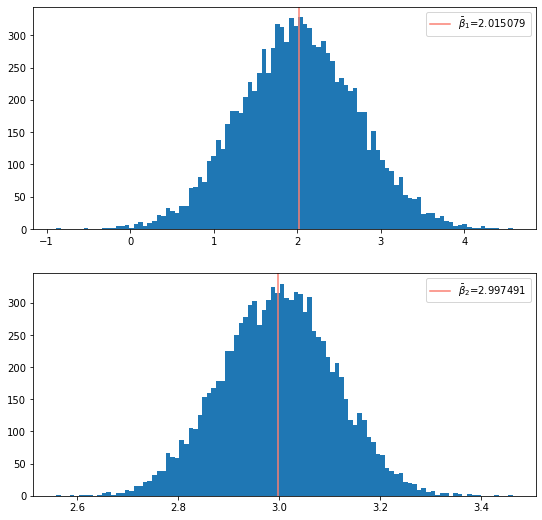

In [48]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9, 9))
ax[0].hist(b1_array, bins=100)
ax[0].axvline(b1_mean, color="salmon", label=r"$\bar{\beta}_1$=%f" % b1_mean)
ax[0].legend()

ax[1].hist(b2_array, bins=100)
ax[1].axvline(b2_mean, color="salmon", label=r"$\bar{\beta}_2$=%f" % b2_mean)
ax[1].legend()
plt.show()

Now we try again with a larger disturbance scaler $a_u = 2$ and keep rest parameters unchanged.

In [ ]:
ols_mt = OLS_Monte_Carlo(beta1=2, beta2=3, N=10, u_scaler=2)
b2_array, b1_array = [], []
for i in range(10000):
    b2, b1 = ols_mt.ols()
    b2_array.append(b2)
    b1_array.append(b1)
b2_mean = np.mean(b2_array)
b1_mean = np.mean(b1_array)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9, 9))
ax[0].hist(b1_array, bins=50)
ax[0].axvline(b1_mean, color="salmon", label=r"$\bar{b}_1$=%f" % b1_mean)
ax[0].legend()

ax[1].hist(b2_array, bins=50)
ax[1].axvline(b2_mean, color="salmon", label=r"$\bar{b}_2$=%f" % b2_mean)
ax[1].legend()
plt.show()

Though the histogram has been scaled as seemingly identical as above, but pay attention to the $x$-axis and vertical line. Apparently the variance of $u$ affects the accuracy of estimates, i.e. the variance of sampling distribution of $b_1$ and $b_2$.

It's straightforward to see why this happens from the formula
$$
\hat{\beta}_{2}=\beta_{2}+\frac{\operatorname{Cov}(X, a_uu)}{\operatorname{Var}(X)}=\beta_{2}+a_u\frac{\operatorname{Cov}(X, u)}{\operatorname{Var}(X)}
$$

We know from statistics course the increase sample is always doing good for quality of estimates, thus we dial it up to $N=100$, rest are unchanged.

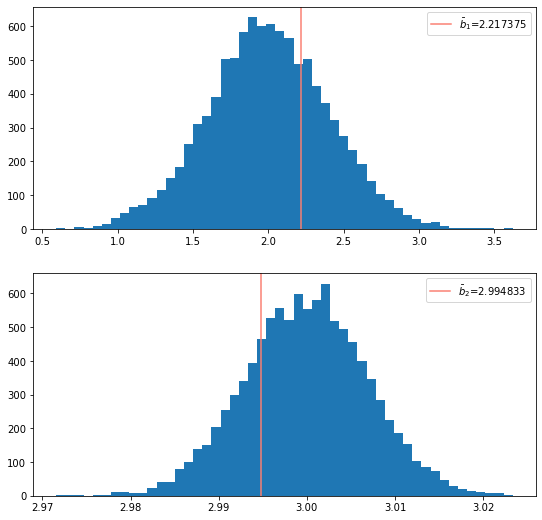

In [21]:
ols_mt = OLS_Monte_Carlo(beta1=2, beta2=3, N=100, u_scaler=2)
b2_array, b1_array = [], []
for i in range(10000):
    b2, b1 = ols_mt.ols()
    b2_array.append(b2)
    b1_array.append(b1)
b2_mean = np.mean(b2)
b1_mean = np.mean(b1)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9, 9))
ax[0].hist(b1_array, bins=50)
ax[0].axvline(b1_mean, color="salmon", label=r"$\bar{b}_1$=%f" % b1_mean)
ax[0].legend()

ax[1].hist(b2_array, bins=50)
ax[1].axvline(b2_mean, color="salmon", label=r"$\bar{b}_2$=%f" % b2_mean)
ax[1].legend()
plt.show()

# <font face="gotham" color="purple"> Statistical Features of Estimates</font>

After a visial exam of sample distributions, now we can formally discuss the statistical features of estimator.

## <font face="gotham" color="purple"> Unbiased of Estimator</font>

If an estimator is biased, we rarely perform any estimation with it, unless you have no choices which is also rare. But how to prove unbiasness of an estimator? 

The _rule of thumb_ is to take expectation on both sides of estimator. Here is the OLS example.
$$
E\left(b_{2}\right)=E\left[\beta_{2}+\frac{\operatorname{Cov}(X, u)}{\operatorname{Var}(X)}\right]=\beta_{2}+E\left[\frac{\operatorname{Cov}(X, u)}{\operatorname{Var}(X)}\right]=\beta_2+\frac{E[\operatorname{Cov}(X, u)]}{E[\operatorname{Var}(X)]}
$$
To show $E[\operatorname{Cov}(X, u)]=0$, rewrite covariance in explicit form
$$
E[\operatorname{Cov}(X, u)]=\frac{1}{n} \sum_{i=1}^{n}\left(X_{i}-\bar{X}\right) E\left(u_{i}-\bar{u}\right)=0
$$
Therefore
$$
E\left(\hat{\beta}_{2}\right)=\beta_{2}
$$
Again take expectation on $b_1$, immediately we get
$$
E(\hat{\beta}_1) = E(\bar{Y})-E(\hat{\beta}_2)E(\bar{X})= E(\bar{Y})-\beta_2\bar{X}=\beta_1
$$
where we used $E(\bar{Y})=\beta_{1}+\beta_{2} \bar{X}$.

## <font face="gotham" color="purple"> Precision of Estimator</font>

If we know the variance of disturbance term, the population variance of $b_1$ and $b_2$ can be derived
$$
\sigma_{\hat{\beta}_1}^{2}=\frac{\sigma_{u}^{2}}{n}\left[1+\frac{\bar{X}^{2}}{\operatorname{Var}(X)}\right]\\\sigma_{\hat{\beta}_2}^{2}=\frac{\sigma_{u}^{2}}{n \operatorname{Var}(X)}
$$
Though we will never really know $\sigma_{u}$, the formulae provide the intuition how the variance of coefficients are determined. 

In the visual example of last section, we have seen that the larger $\sigma_{u}$ causes larger $\sigma_{\hat{\beta}_1}^{2}$ and $\sigma_{\hat{\beta}_2}^{2}$, here the formulae also present the relation. 

And there are two ways to contract the variance of $b_1$ and $b_2$, one is increasing sample size $n$, the other is increasing $\operatorname{Var}(X)$.

In practice, we substitute $\sigma_{u}^{2}$ by its unbiased estimator
$$
s_{u}^{2}=\frac{n}{n-2} \operatorname{Var}(e)
$$

where $\operatorname{Var}(\epsilon)$ is the sample variance of residuals. The term $\frac{n}{n-2}$ is for upscaling variance, because generally residuals are smaller than disturbance term, this is determined by its mathematical nature. You will get a very clear linear algebraic view in advanced econometric theory. 

After plug-in we get the _standard error_ of $\hat{\beta}_1$ and $\hat{\beta}_2$
$$
\text { s.e. }\left(\hat{\beta}_1\right)=\sqrt{\frac{s_{u}^{2}}{n}\left[1+\frac{\bar{X}^{2}}{\operatorname{Var}(X)}\right]}\\
\text { s.e. }\left(\hat{\beta}_2\right)=\sqrt{\frac{s_{u}^{2}}{n \operatorname{Var}(X)}}
$$
The standard error is used when we are referring to the _standard deviation of sampling distribution of estimates_, specifically in econometric term, regression coefficients.

# <font face="gotham" color="purple"> Hypothesis Testing and $t$-Test</font>

Essentially, hypothesis testing in econometrics is the same as statistics. We propose a theory and test against data collected by experiment or sampling. 

That being said, in econometrics, we mainly investigate if the linear relation between independent and dependent variables is plausible, so we rarely test a specific null hypothesis such that $\beta_2 = 2$, but rather $\beta_2 =0$. Therefore
$$
H_0: \beta_1 = 0, \beta_2 =0\\
H_1: \beta_1 \neq 0, \beta_2 \neq 0 
$$

Let's reproduce the house price example. We have the estimates, but we would like to investigate how reliable the results are. Reliability hinges on relativity, that means even if the absolute value of estimates are small, such as $.1$, as long as the standard error are smaller enough, such as $.01$, we can safely conclude a rejection of null hyphothesis without hesitation. 

$t$ statistic of $\hat{\beta}_1$ and $\hat{\beta}_2$ are 
$$
\frac{\hat{\beta}_1-\beta_1^0}{s.e.(\hat{\beta}_1)}\qquad\frac{\hat{\beta}_2-\beta_2^0}{s.e.(\hat{\beta}_2)}
$$
where $\beta^0$ is null hypothesis. 

Generally, statistics are intuitive to interpret, it measures how many standard deviations (with known $\sigma$) or standard errors (with unknown $\sigma$) away from the null hypothesis. The further way, the stronger evidence supporting the rejection of null hypothesis. 

b1 estimate: -29181.1698
b2 estimate: 1.1010


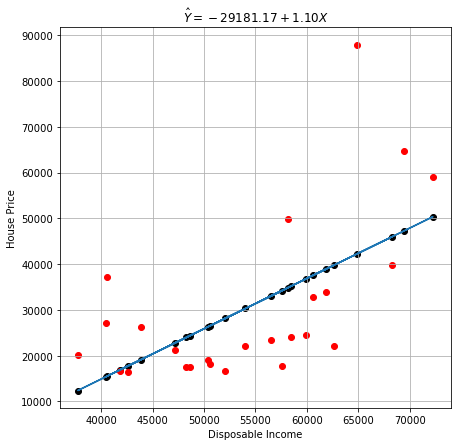

In [22]:
df = pd.read_excel(
    "Basic_Econometrics_practice_data.xlsx", sheet_name="CN_Cities_house_price"
)
s_ols_house_income = S_OLS(df["salary"], df["house_price"])
Y_hat, b2, b1 = s_ols_house_income.ols()
s_ols_house_income.ols_plot("Disposable Income", "House Price")
resid = df["house_price"] - Y_hat

Compute $t$-statistic as in formulae

In [23]:
n = len(df["house_price"])
s_u_sqr = n / (n - 2) * np.var(resid)

std_err_b1 = np.sqrt(
    s_u_sqr / n * (1 + np.mean(df["salary"]) ** 2 / np.var(df["salary"]))
)
std_err_b2 = np.sqrt(s_u_sqr / (n * np.var(df["salary"])))

t_b1 = b1 / std_err_b1
t_b2 = b2 / std_err_b2
print("t_b1:{:.4f}".format(t_b1))
print("t_b2:{:.4f}".format(t_b2))

t_b1:-1.7580
t_b2:3.6349


Seems both $t$'s are far away from null hypothesis $\beta^0=0$, but how far is real far? Unless we have a quantitative criterion, the interpretations won't sound objective. 

That's why we have **significant level** (denoted as $\alpha$) as the decisive criterion. The common levels is $5\%$ and $1\%$. If $t$ falls on the right of **critical value** of $t$ at $5\%$, we can conclude a rejection of null hypothesis.
$$
t > t_{.05}
$$
However in econometrics two-side test is more common, then rejection rules of $\alpha=.05$ are
$$
t<t_{-.025} \text{ and }t > t_{.025}
$$
Critical value of $t$-distribution is obtained by ```sp.stats.t.ppf```, and the shape of $t$-distribution approximate to normal distribution as degree of freedom raise.

The two-side test $t$-statistic is

In [24]:
t_crit = sp.stats.t.ppf(0.975, df=n - 1)
t_crit

2.0638985616280205

Therefore we conclude a rejections of $\beta_2=0$ ($t_{b_2}>t_{crit}$) but fail to reject $\beta_1=0$ ($t_{\hat{\beta}_1}<t_{crit}$). 

The $\hat{\beta}_2=1.1010$ is interpreted that every $1$ yuan increment of disposable income is accompanied by raising $1.1010$ yuan on house price.

In contrast, $\hat{\beta}_1= -29181.16$ can't be interpreted that if every family has $0$ disposable income, the house price will be $-29181.16$, because it doesn't have any logical or economic sense. So the rule of thumb for interpretation of constant term: _it's unnecessary to interpret constant coefficient if the it has no logical sense_.

<div style="background-color:Bisque; color:DarkBlue; padding:30px;">
<b>Side note of $t$-distribution</b><br>

<p>Here below is a figure for refreshing $t$-statistics, we set $\alpha=.05$. The first axes demonstrates how $t$-statistic changes as degree of freedom raises, the second shows that $t$-distribution approximates normal distribution indefinitely with rising degree of freedom.</p>

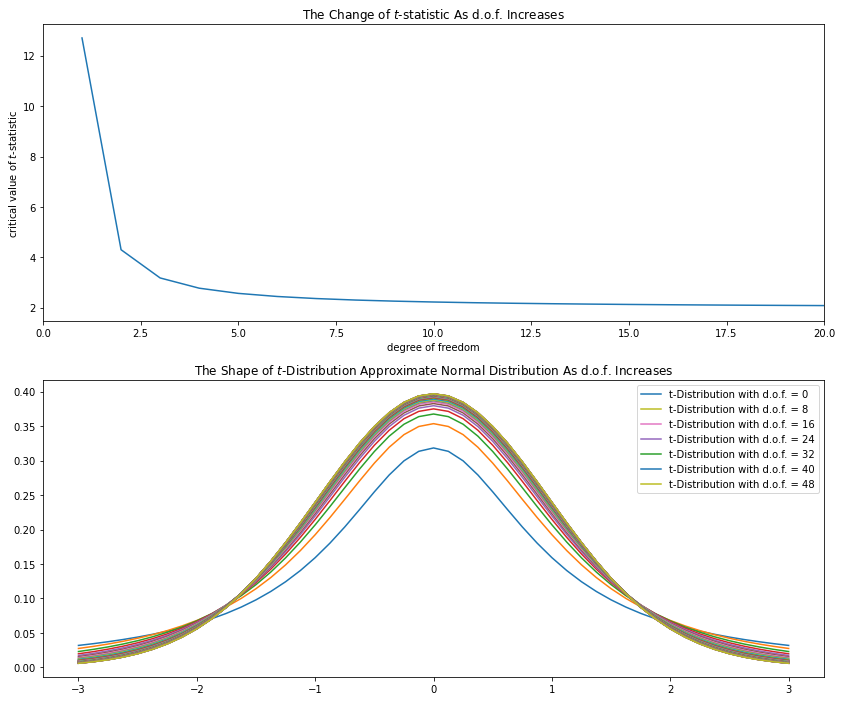

In [25]:
degree_frd = np.arange(1, 50, 1)
t_array = sp.stats.t.ppf(0.975, df=degree_frd)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 12))
ax[0].plot(degree_frd, t_array)
ax[0].set_xlim([0, 20])
ax[0].set_xlabel("degree of freedom")
ax[0].set_ylabel("critical value of $t$-statistic")
ax[0].set_title("The Change of $t$-statistic As d.o.f. Increases")
x = np.linspace(-3, 3, len(degree_frd))
for i in range(len(degree_frd)):
    t_pdf = sp.stats.t.pdf(
        x, degree_frd[i], loc=0, scale=1
    )  # pdf(x, df, loc=0, scale=1)
    if i % 8 == 0:
        ax[1].plot(x, t_pdf, label="t-Distribution with d.o.f. = {}".format(i))
    else:
        ax[1].plot(x, t_pdf)
ax[1].set_title(
    "The Shape of $t$-Distribution Approximate Normal Distribution As d.o.f. Increases"
)
ax[1].legend()
plt.show()

# <font face="gotham" color="purple"> $p$-Values</font>

Personally, I myself prefer to $p$-values. It is more informative than $t$-statistic, $p$-value gives the probability of obtaining corresponding $t$-statistic if null hypothesis is true, which is exactly the probability of **type I error**. 

With proper use of ```sp.stats.t.cdf```, we can access $p$-value conveniently. 

In [26]:
1 - sp.stats.t.cdf(
    t_b2, df=n
)  # because t_b2 is positive, so p-value should be deducted from 1, if negative then without

0.0006284669089314798

$p$-value tells that if null hypothesis is true, the probability of obtaining $t_{b_2}=3.6349$ or even higher is merely $0.0006$. That means, very unlikely the null hypothesis is true, we can safely reject null hypothesis with a tiny probability of Type I error.

Medical researches conventionally uses $p$-value, econometrics tend to use estimates with standard error bracketed below. But they just different ways of expressing the same ideas, pick based on your preference unless you don't are writing an economic paper. 

<div style="background-color:Bisque; color:DarkBlue; padding:30px;">
<i><b>Side note of Type I and II Error</b><br>
The blue shaded area are genuinely generated by null distribution, however they are too distant (i.e. $2\sigma$ away) from the mean ($0$ in this example), and they are mistakenly rejected, this is what we call <b>Type I Error</b>.
<br>
<br>
The orange shaded area are actually generated by alternative distribution, however they are in the adjacent area of mean of null hypothesis, so we failed to reject they, but wrongly. And this is called <b>Type II Error</b>.
<br>
<br>
As you can see from the chart, if null distribution and alternative are far away from each other, the probability of both type of errors diminish to trivial. </i>
</div>

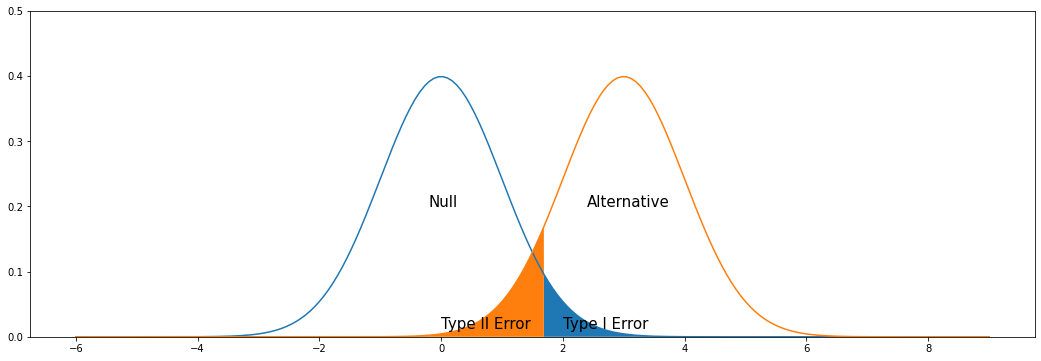

In [27]:
from plot_material import type12_error

type12_error()

# <font face="gotham" color="purple"> Confidence Interval </font>

Why bother with confidence interval if we have hypothesis testing?

If you have a theory that house price has a certain linear relationship with disposable income, you test theory with model, this is called _hypothesis testing_. But what if you don't have a theory yet, and runs the regression, you are wondering how confident these estimates can represent the true parameters, the range that you feel confident is called **confidence interval**.

These two procedures complementing each other, that's why we see them often reported together.

Recall the rejection rules are
$$
\frac{\hat{\beta}-\beta}{\text { s.e. }\left(\hat{\beta}\right)}>t_{\text {crit }} \quad \text { or } \quad \frac{\hat{\beta}-\beta}{\text { s.e. }\left(\hat{\beta}\right)}<-t_{\text {crit }}
$$
If we slight rearrange and join them, we get the confidence interval
$$
\hat{\beta}-\text { s.e. }\left(b\right) \times t_{\text {crit }} \leq \beta\leq \hat{\beta}+\text { s.e. }\left(\hat{\beta}\right) \times t_{\text {crit }}
$$
The higher significance level, the smaller $\alpha$ is, the larger confidence interval (because of larger $t_{crit}$). For example, if the significance level is $\alpha=.05$, then confidence level is $0.95$.

Here's the confidence interval ($95\%$) of our house price example.

In [28]:
t_crit = sp.stats.t.ppf(0.975, df=n - 1)
print("C.I. of b1: [{}, {}]".format(b1 - t_crit * std_err_b1, b1 + t_crit * std_err_b1))
print("C.I. of b2: [{}, {}]".format(b2 - t_crit * std_err_b2, b2 + t_crit * std_err_b2))

C.I. of b1: [-63439.54567466995, 5077.206045321891]
C.I. of b2: [0.4758472405690616, 1.7261233292171854]


There are $95\%$ chances the true parameter $\beta$ will 'fall' in this confidence interval.

# <font face="gotham" color="purple"> One-Tailed vs Two-Tailed Test </font>

So far we have been discussing about two-tailed test, but there are scenarios that one-tailed test make more sense. In our house price example, some practitioners would prefer to test the theory or common sense: _disposable income would not have negative effects on house price_. The alternative would be that _disposable income would have either no effect or positive effects on house price_.

Thus the one-tailed test hypotheses are
$$
H_0: \beta_2<0\\
H_1: \beta_2\geq 0
$$
In one-tailed test, we don't split $\alpha$ anymore since there is only one side, that means the critical value will be smaller, easier to reject null hypothesis. 

Here is $t_{crit}$ of $\alpha=5\%$. However, these are conventional rules, if you still prefer $2.5\%$ on one-side, feel free to do so. Especially you have a very significant $t$-statistic, such as $10$, one-tailed or two-tailed won't really matter. 

In [29]:
t_crit_oneside = sp.stats.t.ppf(0.95, df=n - 1)
t_crit_oneside

1.7108820799094275

So here the rule of thumb for one-tailed test.

<div style="background-color:Bisque; color:DarkBlue; padding:30px;">
<i><b>Rules of Thumb for One-Tailed Test</b><br>
1. If the theory or common sense supports one side test, e.g. household consumption increases as disposable incomes increase.<br>
2. If two-tailed test failed to reject, but one-tailed reject, you can report one-tailed test results if the first rule satisfied too.
</div>

# <font face="gotham" color="purple"> $F$-test</font>

$F$-test is based on _Analysis of Variance_ (ANOVA), the goal is to test **multiple restrictions** on the regression model. In simple linear regression model, the **joint hypothesis** is usually
\begin{align}
H_0&: \beta_1 = 0,\qquad\beta_2=0\\
H_1&: \text{One or more restrictions does not hold}
\end{align}

once you have ANOVA done, $F$-statistic is an natural byproduct.
$$
F=\frac{E S S /(k-1)}{R S S /(n-k)}
$$
where $k$ is the number of number of parameters in the regression model, here in simple regression model $k=2$ and $n$ is the sample size.

You might have doubt now: why aren't we using same old $t$-tests such that
$$
H_0: \hat{\beta}_1=0 \qquad H_0: \hat{\beta}_2=0 \qquad \\
H_1: \hat{\beta}_1\neq0 \qquad H_1: \hat{\beta}_2\neq0\qquad\\
$$

Apparently, the number of $t$-tests will be as large as ${k \choose 2} $ where $k$ is the number of parameters. If there are $5$ parameters, then we have to test ${5 \choose 2}=10$ pairs. With $95\%$ confidence level, $10$ $t$-tests would cut back confidence level dramatically to $95\%^{10}=59.8\%$, which also means the probability of _type I_ error would be around $40\%$.

We have user-defined functions written in the OLS class, so $F$-statistic is 

In [30]:
f_stat = (ess / (2 - 1)) / (rss / (len(df["salary"]) - 2))
print("F-statistic is {:.4f}.".format(f_stat))

F-statistic is 13.2126.


In [31]:
p_value = 1 - sp.stats.f.cdf(
    f_stat, 1, len(df["salary"]) - 2
)  # sp.stats.f.cdf(df on nominator, df on denom)
print("p-value is {:.4f}.".format(p_value))

p-value is 0.0014.


To explore further, we can even prove that in simple linear regression $F$ are the just the square of $t$.

<div style="background-color:Bisque; color:DarkBlue; padding:30px;">
<i><b>$F$-statistic and $t$-statistic</b><br>
Here's the proof that $F$ and $t$ are connected
$$
F=\frac{R^{2}}{\left(1-R^{2}\right) /(n-2)}=\frac{\frac{\operatorname{Var}(\hat{Y})}{\operatorname{Var}(Y)}}{\left\{1-\frac{\operatorname{Var}(\hat{Y})}{\operatorname{Var}(Y)}\right\} /(n-2)}\\
=\frac{\frac{\operatorname{Var}(\hat{Y})}{\operatorname{Var}(Y)}}{\left\{\frac{\operatorname{Var}(Y)-\operatorname{Var}(\hat{Y})}{\operatorname{Var}(Y)}\right\} /(n-2)}=\frac{\operatorname{Var}(\hat{Y})}{\operatorname{Var}(\varepsilon) /(n-2)}\\
=\frac{\operatorname{Var}\left(\hat{\beta}_{1}+\hat{\beta}_{2} X\right)}{\left\{\frac{1}{n} \sum_{i=1}^{n} \varepsilon_{i}^{2}\right\} /(n-2)}=\frac{\hat{\beta}_{2}^{2} \operatorname{Var}(X)}{\frac{1}{n} s_{u}^{2}}=\frac{\hat{\beta}_{2}^{2}}{\frac{s_{u}^{2}}{n \operatorname{Var}(X)}}=\frac{\hat{\beta}_{2}^{2}}{\left[\operatorname{s.e.} \left(\hat{\beta}_{2}\right)\right]^{2}}=t^{2}
$$
</div>

<div style="background-color:Bisque; color:DarkBlue; padding:30px;">
<i><b>$F$-statistic and $R^2$</b><br>
$F$-statistic is a different angle of evaluating the goodness of fit, it can be shown that $F$ and $R^2$ are closely connected, divide both nominator and denominator by $TSS$:
$$
F=\frac{(E S S / T S S) /(k-1)}{(R S S / T S S) /(n-k)}=\frac{R^{2} /(k-1)}{\left(1-R^{2}\right) /(n-k)}
$$
We prefer to $F$ for hypothesis test, it's because critical value of $F$ is straightforward, and critical value of $R^2$ has to be calculated based on $F_{crit}$:
$$
R_{\mathrm{crit}}^{2}=\frac{(k-1) F_{\mathrm{crit}}}{(k-1) F_{\text {crit }}+(n-k)}
$$
</div>

# <font face="gotham" color="purple">Regression vs Correlation</font>

Here is the message for all beginner that misinterpret regression relationship as causation.

<div style="background-color:Bisque; color:DarkBlue; padding:30px;">
<i><b>Does Regression Imply Causation</b><br>

It's tempting to interpret regression result as causality, but it's not. <b>Regression only implies a statistical relationship</b>, the independent variables may or may not be the cause of dependent variables, sometimes we know thanks to theories, sometimes we don't.
    
For instance, researches found that parents with higher education tend to have healthier children, but this is hardly a causality. Perhaps higher education parents are in general wealthier, they can afford decent medical packages. Or they spend time with their kids on sports and dining. We can form some hypothesis, but not a definite causality based on one regression.
</div>

But regressions do resemble the correlation to some extent

<div style="background-color:Bisque; color:DarkBlue; padding:30px;">
<i><b>Does Regression Imply Correlation</b><br>
From formula of $\hat{\beta}_2$
$$
\hat{\beta}_2 =\frac{\text{Cov}(X, Y)}{\text{Var}(X)}
$$
We can see the regression indeed has a component of correlation (covariance in the formula), but it's normalized by variance (i.e. $\sigma_X\sigma_X$) rather than $\sigma_X\sigma_Y$. To compare with correlation coefficient of $X$ and $Y$ 
$$
\rho_{XY}=\frac{\text{Cov}(X, Y)}{\sigma_X\sigma_Y}
$$
We can see one important difference is that regression coefficient does not treat both variables symmetrically, but correlation coefficient does. Joining two formulae, we have a different view of the coefficient.<br><br>
$$
\hat{\beta}_2=\frac{\rho_{XY}\sigma_X\sigma_Y}{\text{Var}(X)}= \frac{\rho_{XY}\sigma_X\sigma_Y}{\sigma_X\sigma_X}=\rho_{XY}\frac{\sigma_Y}{\sigma_X}
$$
    
Besides that, the purpose of these two techniques are different, regression are mainly predicting dependent variables behaviors, but correlation are mainly summarizing the direction and strength among two or more variables. 
</div>

Maybe a chart can share insight of their relationship. All data are simulated by $u\sim N(0, 1)$. It's easy to notice the smaller correlation implies a smaller slope coefficient in terms of absolute value. And larger disturbance term also implies lower correlation coefficient. 

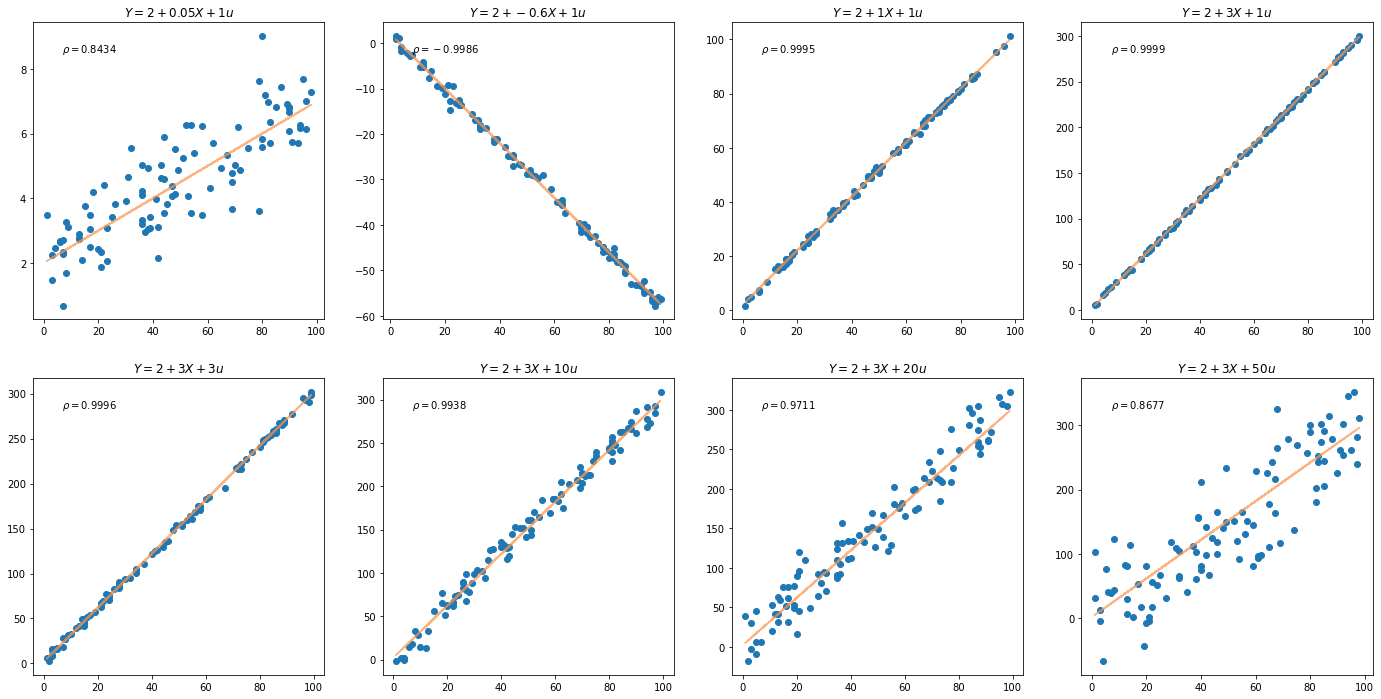

In [32]:
from plot_material import reg_corr_plot

reg_corr_plot()

# <font face="gotham" color="purple"> Joint Confidence Region</font>

**Joint confidence region** are the joint distribution of regression coefficients, it is theoretically an ellipse. It shows the distributed location of the coefficient pair. 

Here is a Monte Carlo simulation, we set $\beta_1 = 3$, $\beta_2 = 4$ and $u\sim N(0, 10)$, run $1000$ times then plot the estimates.

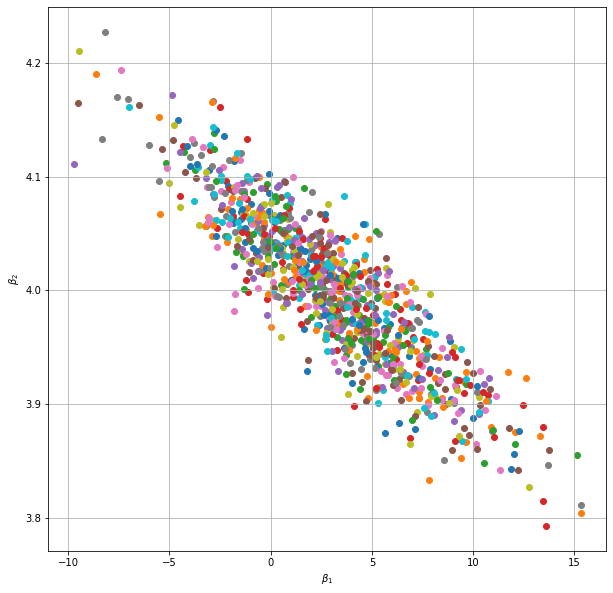

In [33]:
beta1, beta2 = 3, 4
beta1_array, beta2_array = [], []
for i in range(1000):
    u = 10 * np.random.randn(30)
    X2 = np.linspace(10, 100, 30)
    Y = beta1 + beta2 * X2 + u

    df = pd.DataFrame([Y, X2]).transpose()
    df.columns = ["Y", "X2"]

    X_inde = df["X2"]
    Y = df["Y"]

    X_inde = sm.add_constant(X_inde)

    model = sm.OLS(Y, X_inde).fit()
    beta1_array.append(model.params[0])
    beta2_array.append(model.params[1])

fig, ax = plt.subplots(figsize=(10, 10))
ax.grid()
for i in range(1000):
    ax.scatter(
        beta1_array[i], beta2_array[i]
    )  # no need for a loop, i just want different colors
ax.set_xlabel(r"$\beta_1$")
ax.set_ylabel(r"$\beta_2$")
plt.show()

But why the joint distribution of coefficient has an elliptic shape? If you take a look at any linear regression plot, it wouldn't be difficult to notice that the high slope coefficient $\beta_2$ would cause low the intercept coefficient $\beta_1$, this is a geometric feature of linear regression model.

And from the plot, we can see the range of $\beta_1$ is much larger than $\beta_2$ and even include $0$, especial the data points are far away from $0$, $\beta_1$ can have erratic results, that's also the reason we don't expect to interpret $\beta_1$ most of time.

# <font face="gotham" color="purple"> Stochastic Regressors</font>

One of G-M condition is $\text{Cov}(X_i, u_i)=0$, assuming $X_i$ is non-stochastic. But we commonly encounters that $X_i$ is stochastic, for instance you sample $10$ family's annual income, you have no clue on how much they are earning eventually, therefore assuming they are stochastic would be more appropriate. 

If $X_i$ is stochastic and distributed independently of $u_i$, it guarantees that $\text{Cov}(X_i, u_i)=0$, but not vice versa.

# <font face="gotham" color="purple"> Maximum Likelihood Estimation</font>

In more advanced level of econometric research, **maximum likelihood estimation**(MLE) is used more often than OLS. The reason is that MLE is more flexible on assumption of disturbance term, i.e. not assuming the normality of the disturbance term. But it requires you to have an assumption of certain distribution, it can be exponential or gamma distribution or whatever. 

We will provide two examples to illustrate the philosophy of MLE, one is to estimate simple linear regression with MLE and the other is to estimate a mean of an exponential distribution.

## <font face="gotham" color="purple"> MLE for Simple Linear Regression </font>

Once you have a dataset, you should know the data are just observations of random variables. For instance, you are about to collect $100$ family's annual income data for year 2021, each family's income is essentially a random variable, hence it follows some distribution, it can be normal distribution or skewed gamma distribution. 

Once the data is collected, the observances are done. Each data point, i.e. $Y_1, Y_2, ..., Y_n$ is just single realization of its distribution, the joint distribution of all random variables is
$$
f\left(Y_{1}, Y_{2}, \ldots, Y_{n}\right)
$$
We assume a simple linear regression $Y_{i}=\beta_{1}+\beta_{2} X_{i}+u_{i}$ model to explain $Y$, then the joint distribution is conditional
$$
f\left(Y_{1}, Y_{2}, \ldots, Y_{n} \mid \beta_{1}+\beta_{2} X_{i}, \sigma^{2}\right)
$$
We also assume each family's income is independent of rest, then joint distribution equals the product of all distributions.
$$
\begin{aligned}
&f\left(Y_{1}, Y_{2}, \ldots, Y_{n} \mid \beta_{1}+\beta_{2} X_{i}, \sigma^{2}\right)=f\left(Y_{1} \mid \beta_{1}+\beta_{2} X_{i}, \sigma^{2}\right) f\left(Y_{2} \mid \beta_{1}+\beta_{2} X_{i}, \sigma^{2}\right) \cdots f\left(Y_{n} \mid \beta_{1}+\beta_{2} X_{i}, \sigma^{2}\right) =\prod_{i=0}^nf\left(Y_{i} \mid \beta_{1}+\beta_{2} X_{i}, \sigma^{2}\right)
\end{aligned}
$$

Now we need to ask ourselves, what distribution does $Y$ follow? It's the same as asking what's the distribution of $u$? It's reasonable to assume $u$ follow normal distribution, so are $Y$'s.
$$
f(Y_i)= \frac{1}{\sigma \sqrt{2\pi}}e^{-\frac{1}{2}\frac{[Y_i-E(Y_i)]^2}{\sigma^2}}=\frac{1}{\sigma \sqrt{2\pi}}e^{-\frac{1}{2}\frac{[Y_i-\beta_1-\beta_2X_i]^2}{\sigma^2}}
$$

Then the joint distribution is the product of this PDF function
$$
\prod_{i=0}^nf\left(Y_{i} \mid \beta_{1}+\beta_{2} X_{i}, \sigma^{2}\right)=\frac{1}{\sigma^{n}(\sqrt{2 \pi})^{n}} e^{-\frac{1}{2} \sum \frac{\left(Y_{i}-\beta_{1}-\beta_{2} X_{i}\right)^{2}}{\sigma^{2}}}
$$

Once we have joint distribution function, in a frequentist view, the observed data is generated by this distribution with certain parameters, in this case $\beta_1, \beta_2$ and $\sigma^2$. So the fundamental the questions are what those parameters are? How to find them?

We give a name to the join distribution function above - **likelihood function**, which means how likely a set of parameters can generate a set of data. We denote likelihood function as $LF(\beta_1, \beta_2, \sigma^2)$.

The MLE, as its name indicates, is to estimate the parameters that in such manner that the probability of generating $Y$'s is the highest. 

To derive a analytical solution, usually we use log form likelihood function
$$
\ln{LF}=\ln{\prod_{i=0}^nf\left(Y_{i} \mid \beta_{1}+\beta_{2} X_{i}, \sigma^{2}\right)} =-\frac{n}{2} \ln \sigma^{2}-\frac{n}{2} \ln (2 \pi)-\frac{1}{2} \sum \frac{\left(Y_{i}-\beta_{1}-\beta_{2} X_{i}\right)^{2}}{\sigma^{2}}
$$

Take derivative with respect to $\beta_1$, $\beta_2$ and $\sigma^2$ and equal them to $0$ will yield the **maximum likelihood estimators** for simple linear regression with assumption of normally distributed disturbance term
\begin{align}
\hat{\beta}_2 &= \frac{\sum_{i=1}^n (X_i - \bar{X})(Y_i-\bar{Y})}{\sum_{i=1}^n(X_i-\bar{X})^2}=\frac{\text{Cov}(X, Y)}{\text{Var}(X)}\\
\hat{\beta}_1 &= \bar{Y}-\beta_2\bar{X}\\
s^2 &= \frac{1}{n} \sum_{i=1}^{n}\left(Y_{i}-\left(\hat{\beta}_{1}+\hat{\beta}_{2} X_{i}\right)\right)^{2} = \frac{1}{n}\sum_{i=1}^n e_i^2
\end{align}

MLE $\hat{\beta}_1$ and $\hat{\beta}_2$ are exactly the same as OLS estimators, only the $s^2$ differs from OLS estimator $s^2 = \frac{\sum e^2_i}{n-2}$. The MLE $s^2$ is biased in small sample, but _consistent_ as sample size increases.

We'll experiment with MLE with simulated data. Generate a data for OLS estimation and print the estimated coefficients.

```statsmodel``` library doesn't have a direct api for maximum likelihood estimation, but we can construct it with ```Scipy```'s ```minimize``` function, so we define a negative log likelihood. The reason of negative function is because ```Scipy``` has only ```minimize``` function.

In [34]:
df = pd.read_excel("Basic_Econometrics_practice_data.xlsx", "CN_Cities_house_price")
df.head()

,cities,house_price,salary
0,Shenzhen,87957,64878
1,Beijing,64721,69434
2,Shanghai,59072,72232
3,Xiamen,49803,58140
4,Guangzhou,39851,68304


In [35]:
y = df["house_price"]
X = df["salary"]

In [36]:
def neg_LL(theta_array):
    y_fitted = theta_array[0] + theta_array[1] * X
    sigma = theta_array[2]
    LL = (
        -(len(y_fitted) / 2) * np.log(theta_array[2] ** 2)
        - (len(y_fitted) / 2) * np.log(2 * np.pi)
        - 1 / (2 * theta_array[2] ** 2) * np.sum((y - y_fitted) ** 2)
    )
    return -LL

In [37]:
theta_start = np.array([1, 1, 1])
res = minimize(neg_LL, theta_start, method="Nelder-Mead", options={"disp": True})

Optimization terminated successfully.
         Current function value: 274.077325
         Iterations: 294
         Function evaluations: 532


In [38]:
results = pd.DataFrame({"parameters": res["x"]})
results.index = ["Intercept", "Slope", "Sigma"]
results.head()

,parameters
Intercept,-29181.169196
Slope,1.100985
Sigma,13962.835305


As you can see the intercept and slope coefficients are the same as OLS, but $\hat{\sigma}$ is underestimated as the theory tells.

## <font face="gotham" color="purple"> MLE for Exponential Distribution </font>

MLE is more general than OLS, it can estimate any parameters as long as you know or assume the distribution, this example we will give an explicit function form for an exponential function. 

Consider 
$$
f(Y_i; \theta) = \theta e^{-\theta Y_i}
$$
The joint distribution (likelihood function) is 
$$
\prod_{i=1}^n f(Y_i; \theta) = \theta^ n  e^{-\theta \sum Y_i}
$$
Log likelihood function is
$$
\ln \prod_{i=1}^n f(Y_i; \theta) = n\ln{\theta} - \theta \sum_{i=1}^n Y_i
$$

Take derivative with respect to $\theta$
$$
\frac{\partial LF}{\partial \theta} = \frac{n}{\theta}-\sum_{i=1}^n Y_i = 0
$$

The result is 
$$
\hat{\theta} = \frac{n}{n \bar{Y}} = \frac{1}{\bar{Y}}
$$

The estimated parameter $\hat{\theta}$ is the reciprocal of mean of $Y_i$.

# <font face="gotham" color="purple">Statsmodels Library </font>

Fortunately, we don't need to program our own toolbox for estimations, ```statsmodels``` library will be our main tool from now on, all the codes are self-explanatory unless it requires further clarification.

The estimation results are reported in as in Stata or Eview, there is a test run below. 

In [39]:
X = df["salary"]
Y = df["house_price"]

X = sm.add_constant(X)  # adding a constant

model = sm.OLS(Y, X).fit()

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            house_price   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     13.21
Date:                Sat, 07 Jan 2023   Prob (F-statistic):            0.00139
Time:                        11:16:08   Log-Likelihood:                -274.08
No. Observations:                  25   AIC:                             552.2
Df Residuals:                      23   BIC:                             554.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.918e+04   1.66e+04     -1.758      0.0

However, you might see some people using $R$-style formula such as
```Y ~ X + Z```, which produces the same results.

In [40]:
df = pd.read_excel(
    "Basic_Econometrics_practice_data.xlsx", sheet_name="CN_Cities_house_price"
)
df.head()

model = smf.ols(formula="house_price ~ salary", data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            house_price   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     13.21
Date:                Sat, 07 Jan 2023   Prob (F-statistic):            0.00139
Time:                        11:16:08   Log-Likelihood:                -274.08
No. Observations:                  25   AIC:                             552.2
Df Residuals:                      23   BIC:                             554.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.918e+04   1.66e+04     -1.758      0.0

In [41]:
res = pd.DataFrame(results.params, columns=["OLS estimates"])
res

,OLS estimates
Intercept,-29181.169815
salary,1.100985


In [42]:
results.params

Intercept   -29181.169815
salary           1.100985
dtype: float64

In [43]:
results.fittedvalues

0     42248.553499
1     47264.642457
2     50345.199284
3     34830.114649
4     46020.529085
5     15460.480532
6     38946.698629
7     37545.144362
8     15383.411562
9     19101.438869
10    36825.099985
11    35198.944719
12    33060.831296
13    30299.560202
14    39720.691285
15    22736.892280
16    12374.418778
17    26266.651103
18    26506.665895
19    34223.471757
20    23977.702696
21    24319.008134
22    28158.143823
23    16928.093917
24    17729.611204
dtype: float64